In [1]:
import numpy as np
import sympy as sp
import matplotlib
import random
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
%matplotlib inline 
%precision 5

'%.5f'

# Residual and Tangent for Linear Momentum Balance

The linear momentum balance problem can be formulated in terms of tensors that are associated with the reference or the deformed coordinates. They are equivalent, but some computations are easier in the reference and some computations are easier in the deformed configuration expressions. Overall, the discrete equations in the deformed configurations are more sparse and therefore more efficient numerically. 

The residual for the weak form in the reference configuration was achieved in previous lectures by discretizing 

$ \int_{B^e}\mathbf{ \sigma} : \delta \mathbf{d}$ 

First, using the discrete nodal positions from the reference and deformed configurations $\mathbf{X}_i^e$ and $\mathbf{x}_i^e$ respectively, we can compute the discrete deformation gradient $\mathbf{F}$ at any point inside of the element and compute the stress $\mathbf{\sigma}$. Then, by introducing the discrete weight function values or nodal variations $\delta \mathbf{u}_i^e$ and taking these outside of the integral leaving behind the shape functins and gradients, we arrive at the corresponding expression for the element residual $\mathbf{R}^e$. 

For the tangent we need the linearization of the weak form. In the current configuration the linearization of the equations is (see also Wriggers pp 137)

$ \int_{B^e} \mathbf{\sigma}: \nabla (\Delta \mathbf{u})^T \nabla \delta \mathbf{u} + \int_{B^e} \Delta \mathbf{\epsilon}: \mathbf{c}:\delta \mathbf{d}$ 

Introducing the discretizations $\delta \mathbf{u} = \sum N_i \delta \mathbf{u}_i^e$ and $\Delta \mathbf{u} = \sum N_i \Delta \mathbf{u}_i^e$ and taking the noda values $\delta \mathbf{u}_i^e$ and $\Delta \mathbf{u}_i^e$ outside of the integral one is left with the element tangent matrix $\mathbf{K}^e$

In order to avoid dealing with the fourth order tensor $\mathbf{c}$, an alternative is to use Voigt notation to compute $\Delta \mathbf{\epsilon}: \mathbf{c}:\nabla \delta \mathbf{d} = (\Delta \mathbf{\epsilon})_{voig}^T\mathbf{D} \cdot(\delta \mathbf{d})_{voigt}$ with $\mathbf{D}$ the $6\times6$ matrix (in 3D) which is the Voigt notation equivalent of the fourth order tensor $\mathbf{c}$. 

## Solution of a simple problem 

To showcase the calculation of the element residual and tangent and the solution of a simple problem, in the following we solve the problem of a square domain subject to Dirichlet boundary conditions of a strip biaxial test. The mesh consists of only 5 elements and 8 nodes. All the displacement on the boundaries will be prescribed and the goal is to solve for the displacement of the internal nodes. The material will be the Neo-Hookean material for plane stress 

$\mathbf{\sigma} = -p \mathbf{I} + 2C_1 \mathbf{b}$ 

where $p=2C_1J^{-2}$ and $J$ is the determinant of the two-dimensional deformation gradient $\mathbf{F}$. The corresponding elasticity tensor is 

$\mathbf{c} = 2p \mathbf{I}\otimes \mathbf{I} + 2p\mathbf{i}$

where $\mathbf{i}$ is the fourth order identity. The voigt notation for this tensor is just a $3\times3$ matrix

$\mathbf{D} = \begin{array}{ccc}4p&2p&0\\2p&4p&0\\0&0&2p \end{array}$

In [2]:
n_node = 8
n_elem = 5
node_X = np.array([[0.,0.],[1.,0.],[1.,1.],[0.,1.],
                   [0.27,0.25],[0.75,0.27],[0.73,0.75],[0.25,0.73]])
elements = np.array([[0,1,5,4],[1,2,6,5],[2,3,7,6],[3,0,4,7],[4,5,6,7]])


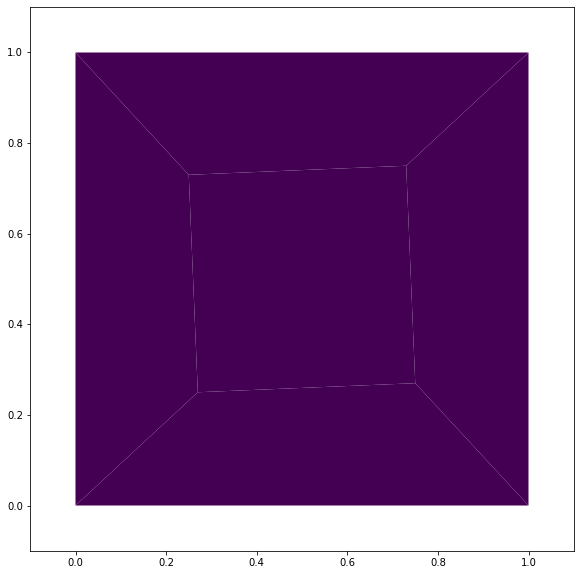

In [3]:
# plot mesh to check
## Plot the mesh 
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlim([-0.1, 1.1])
ax.set_ylim([-0.1, 1.1])
ax.set_aspect('equal')
patches = []
#viridis = matplotlib.cm.get_cmap('viridis', 50)
colors = np.zeros((n_elem))
for i in range(n_elem):
    n1 = elements[i,0]
    n2 = elements[i,1]
    n3 = elements[i,2]
    n4 = elements[i,3]
    polygon = Polygon([node_X[n1],node_X[n2],node_X[n3],node_X[n4]], closed=True)
    patches.append(polygon)
    colors[i] = 100.
p = PatchCollection(patches)
p.set_array(colors)
ax.add_collection(p)

In [4]:
# Shape functions and derivatives 

def Nvec(xi,eta):
    return 0.25*np.array([(1-xi)*(1-eta),(1+xi)*(1-eta),(1+xi)*(1+eta),(1-xi)*(1+eta)])

def dNvecdxi(xi,eta):
    return 0.25*np.array([[(-1)*(1-eta),(+1)*(1-eta),(+1)*(1+eta),(-1)*(1+eta)],\
                          [(1-xi)*(-1),(1+xi)*(-1),(1+xi)*(+1),(1-xi)*(+1)]])

In [24]:
## create DOF map 
node_x = np.zeros(node_X.shape)
DOF_fmap = np.zeros((n_node,2),dtype=int)
DOF_imap = [] 
dof = 0
for i in range(n_node):
    X = node_X[i]
    if X[0]<0.001 and X[1]<0.001:
        DOF_fmap[i,0] = -1
        DOF_fmap[i,1] = -1
        node_x[i,0] = 0.0
        node_x[i,1] = 0.0 
    elif X[1]<0.001 and X[0]>0.999:
        DOF_fmap[i,1] = -1
        node_x[i,1] = 0.0 
        DOF_fmap[i,0] = -1
        node_x[i,0] = 1.2
    elif X[0]<0.001 and X[1]>0.999:
        DOF_fmap[i,0] = -1
        node_x[i,0] = 0.0 
        DOF_fmap[i,1] = dof
        node_x[i,1] = 1.0 
        dof +=1 
        DOF_imap.append([i,1])
    elif X[0]>0.999 and X[1]>0.999:
        DOF_fmap[i,0] = -1
        node_x[i,0] = 1.2 
        DOF_fmap[i,1] = dof 
        node_x[i,1] = 1.0 
        dof +=1 
        DOF_imap.append([i,1])
    else:
        DOF_fmap[i,0] = dof
        DOF_fmap[i,1] = dof+1
        node_x[i,0] = X[0]
        node_x[i,1] = X[1]
        dof+=2 
        DOF_imap.append([i,0])
        DOF_imap.append([i,1])
        node_x[i,0]
print('DOF_fmap')
print(DOF_fmap)
print('DOF_imap')
print(DOF_imap)
print('ndof')
print(dof)

DOF_fmap
[[-1 -1]
 [-1 -1]
 [-1  0]
 [-1  1]
 [ 2  3]
 [ 4  5]
 [ 6  7]
 [ 8  9]]
DOF_imap
[[2, 1], [3, 1], [4, 0], [4, 1], [5, 0], [5, 1], [6, 0], [6, 1], [7, 0], [7, 1]]
ndof
10


In [26]:
# applyt the deformation to all the boundary nodes in the mesh, for the rest just keep original coords
node_x = np.zeros(node_X.shape)
for i in range(n_node):
    X = node_X[i]
    # first initialize with the same as original
    node_x[i] = X
    # but then apply boundary conditions
    if X[0]<0.00001: 
        node_x[i,0] = 0.
    if X[1]<0.00001: 
        node_x[i,1] = 0.
    if X[0]>0.9999: 
        node_x[i,0] = 1.2
    if X[1]>0.9999: 
        node_x[i,1] = 1.


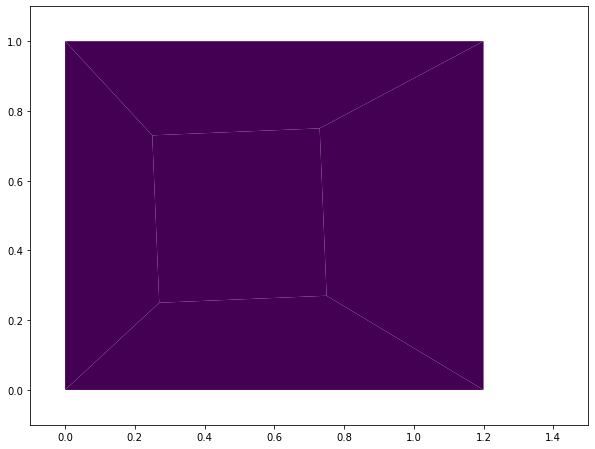

In [25]:
## Plot the deformed mesh 
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlim([-0.1, 1.5])
ax.set_ylim([-0.1, 1.1])
ax.set_aspect('equal')
patches = []
#viridis = matplotlib.cm.get_cmap('viridis', 50)
colors = np.zeros((n_elem))
for i in range(n_elem):
    n1 = elements[i,0]
    n2 = elements[i,1]
    n3 = elements[i,2]
    n4 = elements[i,3]
    polygon = Polygon([node_x[n1],node_x[n2],node_x[n3],node_x[n4]], closed=True)
    patches.append(polygon)
    colors[i] = 0
p = PatchCollection(patches)
p.set_array(colors)
ax.add_collection(p)

## Compute the element residual and tangent and assemble into global residual and tangent



In [26]:
# putting it inside a function
def assembleRRKK():
    # assemble total residual 
    RR = np.zeros((dof))
    # assemble the total tangent 
    KK = np.zeros((dof,dof))
    # loop over elements
    for ei in range(n_elem): 
        # initialize the residual for this element
        Re = np.zeros((8))
        # initialize the tangent for this element
        Ke = np.zeros((8,8))

        # nodes that make up this element 
        node_ei = elements[ei]
        # reference coordinates of the nodes making up this element (init to zero, fill in a loop)
        node_X_ei = np.zeros((4,2))
        # deformed coordinates of the nodes making up this element (init to zero, fill in a loop)
        node_x_ei = np.zeros((4,2))
        for ni in range(4):
            node_X_ei[ni] = node_X[node_ei[ni]]
            node_x_ei[ni] = node_x[node_ei[ni]]

        # also, do a proper integration with four integration points 
        # Loop over integration points
        # location and weight of integration points 
        IP_xi = np.array([[-1./np.sqrt(3),-1./np.sqrt(3)],[+1./np.sqrt(3),-1./np.sqrt(3)],\
                          [+1./np.sqrt(3),+1./np.sqrt(3)],[-1./np.sqrt(3),+1./np.sqrt(3)]])
        IP_wi = np.array([1.,1.,1.,1.])
        for ip in range(4):
            xi  = IP_xi[ip,0]
            eta = IP_xi[ip,1]
            wi = IP_wi[ip]
            # eval shape functions 
            Ns = Nvec(xi,eta)
            # eval the isoparametric map for the reference and deformed points corresponding to xi,eta = 0
            X = np.zeros((2))
            x = np.zeros((2))
            for ni in range(4):
                X += Ns[ni]*node_X_ei[ni]
                x += Ns[ni]*node_x_ei[ni]

            # evaluate the Jacobians, first derivative of shape functions with respect to xi space then Jacobians 
            dNsdxi = dNvecdxi(xi,eta)
            dXdxi = np.zeros((2,2))
            dxdxi = np.zeros((2,2))
            for ni in range(4):
                dXdxi += np.outer(node_X_ei[ni],dNsdxi[:,ni])
                dxdxi += np.outer(node_x_ei[ni],dNsdxi[:,ni])

            # get gradient of basis function with respect to X using inverse jacobian 
            JinvT = np.linalg.inv(dXdxi).transpose()
            dNsdX = np.dot(JinvT,dNsdxi)

            # get gradient of basis function with respect to x using inverse jacobian, the other one 
            jinvT = np.linalg.inv(dxdxi).transpose()
            dNsdx = np.dot(jinvT,dNsdxi)

            # get the deformation gradient 
            F = np.zeros((2,2))
            for ni in range(4):
                F += np.outer(node_x_ei[ni],dNsdX[:,ni])
            # compute the stress
            detF = np.linalg.det(F)
            b = np.dot(F,F.transpose())
            c1 = 1.0 
            p = 2*c1/(detF*detF)
            sigma = -p*np.eye(2) + 2*c1*b

            # compute the variation of the symmetric velocity gradient by moving one node and one component
            # of that node at a time, except if the node is on the boundary in which case no variation is allowed
            for ni in range(4):
                deltav = np.zeros((2))
                for ci in range(2):
                    # note, no worries about the boundary because we will get rid of the corresponding rows
                    # of the residual because they wont be zero 
                    deltav[ci] = 1
                    gradx_v = np.outer(deltav,dNsdx[:,ni])
                    deltad = 0.5*(gradx_v + gradx_v.transpose())
                    Re[ni*2+ci] += wi*np.linalg.det(dxdxi)*np.tensordot(sigma,deltad)

                    # ASSEMBLE INTO GLOBAL RESIDUAL (I didn't ask for this)
                    dofa = DOF_fmap[node_ei[ni],ci]
                    if dofa>-1:
                        RR[dofa] += wi*np.linalg.det(dxdxi)*np.tensordot(sigma,deltad)
                    #print('dofa')
                    #print(dofa)
                    ## 2 more for loops for the increment Delta u
                    for nj in range(4):
                        Deltau = np.zeros((2))
                        for cj in range(2):
                            Deltau[cj]=1
                            gradx_Du = np.outer(Deltau,dNsdx[:,nj])
                            Deltaeps = 0.5*(gradx_Du + gradx_Du.transpose())
                            
                            ## ELEMENT TANGENT
                            # Initial stress component (also called geometric component) is 
                            # sigma: (gradDeltau^T gradv)
                            Kgeom = np.tensordot(sigma,np.dot(gradx_Du.transpose(),gradx_v))
                            # Material component, need to put things in voigt notation for easy computation
                            deltad_voigt = np.array([deltad[0,0],deltad[1,1],2*deltad[0,1]])
                            Deltaeps_voigt = np.array([Deltaeps[0,0],Deltaeps[1,1],2*Deltaeps[0,1]])
                            D = np.array([[4*p,2*p,0],[2*p,4*p,0],[0,0,2*p]])
                            Kmat = np.dot(Deltaeps_voigt,np.dot(D,deltad_voigt))
                            # add to the corresponding entry in Ke and dont forget other parts of integral
                            Ke[ni*2+ci,nj*2+cj] += wi*np.linalg.det(dxdxi)*(Kgeom+Kmat)
                            # assemble into global 
                            dofb = DOF_fmap[node_ei[nj],cj]
                            #print('dofb')
                            #print(dofb)
                            if dofa>-1 and dofb>-1:
                                KK[dofa,dofb] += wi*np.linalg.det(dxdxi)*(Kgeom+Kmat)
                            
    return RR,KK
                            
        

In [55]:
# in case you need to restart 
# applyt the deformation to all the boundary nodes in the mesh, for the rest just keep original coords
node_x = np.zeros(node_X.shape)
for i in range(n_node):
    X = node_X[i]
    # first initialize with the same as original
    node_x[i] = X
    # but then apply boundary conditions
    if X[0]<0.00001: 
        node_x[i,0] = 0.
    if X[1]<0.00001: 
        node_x[i,1] = 0.
    if X[0]>0.9999: 
        node_x[i,0] = 1.1
    if X[1]>0.9999: 
        node_x[i,1] = 1.


In [27]:
## Newton Raphson 
res = 1
iter = 0
tol = 1e-5
itermax = 20
while res>tol and iter<itermax:
    RR,KK = assembleRRKK()
    res = np.linalg.norm(RR)
    incr_u = -np.linalg.solve(KK,RR)
    # and only some of the nodes need this increment
    for i in range(dof):
        nici = DOF_imap[i]
        ni = nici[0]
        ci = nici[1]
        node_x[ni,ci] += incr_u[i]
    iter +=1
    print('iter %i'%iter)
    print(res)

iter 1
5.838121231079067
iter 2
0.8422519949383888
iter 3
0.7464378143091539
iter 4
0.4434706439242071
iter 5
0.3177442718795825
iter 6
0.2112674878540405
iter 7
0.14334365897495494
iter 8
0.09578105711072679
iter 9
0.06394243845991604
iter 10
0.042474921764129446
iter 11
0.02815469266798964
iter 12
0.018620928867073686
iter 13
0.012299019199912309
iter 14
0.008114761557059088
iter 15
0.005350305427681615
iter 16
0.0035258325316083355
iter 17
0.002322731169167893
iter 18
0.001529800191287954
iter 19
0.0010074024195162803
iter 20
0.0006633234523573836


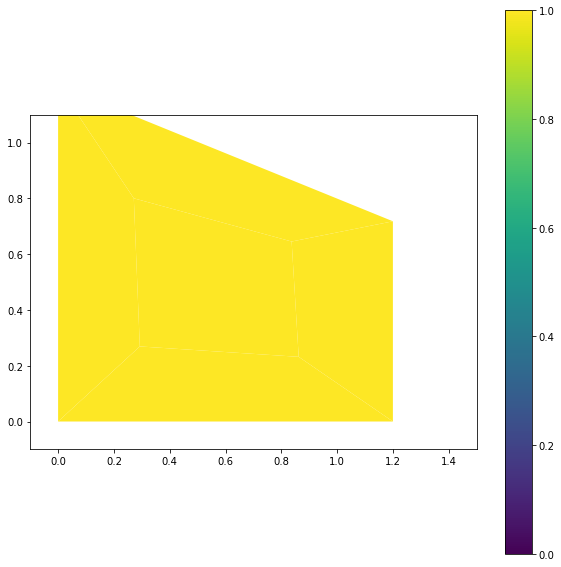

In [28]:
## Plot the deformed mesh, evaluate the stress at the center
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlim([-0.1, 1.5])
ax.set_ylim([-0.1, 1.1])
ax.set_aspect('equal')
patches = []
#viridis = matplotlib.cm.get_cmap('viridis', 50)
colors = np.zeros((n_elem))
for i in range(n_elem):
    n1 = elements[i,0]
    n2 = elements[i,1]
    n3 = elements[i,2]
    n4 = elements[i,3]
    polygon = Polygon([node_x[n1],node_x[n2],node_x[n3],node_x[n4]], closed=True)
    patches.append(polygon)
    # compute stress at center 
    xi  = 0
    eta = 0
    # eval shape functions 
    Ns = Nvec(xi,eta)
    # eval the isoparametric map 
    X = Ns[0]*node_X[n1]+Ns[1]*node_X[n2]+Ns[2]*node_X[n3]+Ns[3]*node_X[n4]
    X = Ns[0]*node_x[n1]+Ns[1]*node_x[n2]+Ns[2]*node_x[n3]+Ns[3]*node_x[n4]
    # evaluate the Jacobians, first derivative of shape functions with respect to xi space then Jacobians 
    dNsdxi = dNvecdxi(xi,eta)
    dXdxi = np.outer(node_X[n1],dNsdxi[:,0])+np.outer(node_X[n2],dNsdxi[:,1])\
            +np.outer(node_X[n3],dNsdxi[:,2])+np.outer(node_X[n4],dNsdxi[:,3])
    dxdxi = np.outer(node_x[n1],dNsdxi[:,0])+np.outer(node_x[n2],dNsdxi[:,1])\
            +np.outer(node_x[n3],dNsdxi[:,2])+np.outer(node_x[n4],dNsdxi[:,3])
    # get gradient of basis function with respect to X using inverse jacobian 
    JinvT = np.linalg.inv(dXdxi).transpose()
    dNsdX = np.dot(JinvT,dNsdxi)
    # get gradient of basis function with respect to x using inverse jacobian, the other one 
    jinvT = np.linalg.inv(dxdxi).transpose()
    dNsdx = np.dot(jinvT,dNsdxi)
    # get the deformation gradient 
    F = np.outer(node_x[n1],dNsdX[:,0])+np.outer(node_x[n2],dNsdX[:,1])\
        +np.outer(node_x[n3],dNsdX[:,2])+np.outer(node_x[n4],dNsdX[:,3])
    detF = np.linalg.det(F)
    b = np.dot(F,F.transpose())
    c1 = 1.0 
    p = 2*c1/(detF*detF)
    sigma = -p*np.eye(2) + 2*c1*b
    #print(sigma)
    colors[i] = sigma[0,0]
p = PatchCollection(patches)
p.set_array(colors)
ax.add_collection(p)
p.set_clim([0, 1])
plt.colorbar(p,ax=ax)

In [29]:
node_x

array([[0.     , 0.     ],
       [1.2    , 0.     ],
       [1.2    , 0.7176 ],
       [0.     , 1.20564],
       [0.29289, 0.26903],
       [0.8624 , 0.23178],
       [0.83709, 0.64508],
       [0.2714 , 0.79998]])